# Stock Trading Strategy using Monte Carlo Simulation
**Author**: 

1. Moch Nabil Farras Dhiya (10120034)
2. Felix Fernando (10120082)

**Institution**: Bandung Institute of Technology


---

**About**: -

# Import Modules

In [1]:
# Extract stock market data
import yfinance as yf

# Importing and transforming file
import pandas as pd

# Data manipulation
import numpy as np
import re # Cleaning texts
import time
import datetime as dt # Datetime manipulation
from scipy.stats import pearsonr # Statistics
from scipy.optimize import minimize # Minimze SR

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Ignore warnings
import warnings

In [2]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Fetch Stock Data

In [3]:
def fetch_data(stock, start_date, end_date):
    data = yf.download(stock, 
                       start = start_date, 
                       end = end_date, 
                       progress = False)

    data = data.reset_index()
    return data

In [4]:
# Start and End Date
start_date = '2021-01-01'
# end_date = '2023-02-28'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

In [5]:
stock = fetch_data(stock = 'ANTM.JK',
                   start_date = start_date, 
                   end_date = end_date)
stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,1970.0,2200.0,1940.0,2190.0,2140.509521,1040753400
1,2021-01-05,2190.0,2340.0,2130.0,2230.0,2179.605713,1139014700
2,2021-01-06,2270.0,2290.0,2130.0,2220.0,2169.831787,629211500
3,2021-01-07,2250.0,2740.0,2240.0,2600.0,2541.244385,1982112200
4,2021-01-08,2640.0,2750.0,2560.0,2600.0,2541.244385,1052618000
...,...,...,...,...,...,...,...
537,2023-03-06,2000.0,2020.0,1955.0,1960.0,1960.000000,74031000
538,2023-03-07,1960.0,1970.0,1930.0,1940.0,1940.000000,76557300
539,2023-03-08,1920.0,1930.0,1870.0,1885.0,1885.000000,144493200
540,2023-03-09,1885.0,1910.0,1870.0,1875.0,1875.000000,75450900


# Data Manipulation

We will do 3 things in order:
1. Make sure the column type is of datetime and float type
2. Drop null and negative values
3. Expand the dataset so it contains the weekend, then interpolate the values

In [6]:
def check_columns(data):
    for col in data.columns:
        if col == 'Date':
            if data[col].dtype == 'str':
                data[col] =  pd.to_datetime(data[col]).date()

        else:
            data[col] = data[col].astype('float64')

    return data

In [7]:
def check_values(data):
    cols = [col for col in data.columns if data[col].dtype == 'float64']

    # Null values
    data = data.dropna(subset = cols)

    # Negative values
    data = data[(data[cols] > 0).all(1)].reset_index(drop = True)

    return data

In [8]:
def expand_data(data, start_date, end_date):
    # Create temporary dataframe
    temp = pd.DataFrame()
    temp['Date'] = pd.date_range(start = start_date, 
                                 end = end_date)

    # Merge the data
    res = pd.merge(temp, data, how = 'left', on = 'Date')
    
    # Interpolate the missing values
    # IDR/USD dataset
    a = res.rolling(3).mean()
    b = res.iloc[::-1].rolling(3).mean()

    c = a.fillna(b).fillna(res).interpolate(method = 'nearest').ffill().bfill()

    res = res.fillna(c)

    return res

In [9]:
def final_data(data, start_date, end_date, criteria):
    # Check columns type
    data = check_columns(data = data)

    # Check null and negative values
    data = check_values(data = data)

    # Expand and interpolate
    data = expand_data(data = data, start_date = start_date, end_date = end_date)

    data = data.set_index('Date')
    
    return data[[criteria]]

In [10]:
stock = final_data(data = stock, start_date = start_date, end_date = end_date, criteria = 'Adj Close')
stock

C:\Users\c640\AppData\Local\Temp\ipykernel_23644\13038183.py:12: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  a = res.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_23644\13038183.py:13: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  b = res.iloc[::-1].rolling(3).mean()


,Adj Close
Date,
2021-01-01,2163.315674
2021-01-02,2163.315674
2021-01-03,2163.315674
2021-01-04,2140.509521
2021-01-05,2179.605713
...,...
2023-03-08,1885.000000
2023-03-09,1875.000000
2023-03-10,1880.000000


# Monte Carlo

In [11]:
def get_return(data):
    data['Daily Return'] = (data.iloc[:, 0] - data.iloc[:, 0].shift(1)) / data.iloc[:, 0].shift(1)
    data = data.dropna()

    sns.displot(data['Daily Return'].dropna(), 
                bins = 50,
                color = 'blue', 
                kde = True)
    plt.title('Daily return distribution')
    plt.show()

    return data

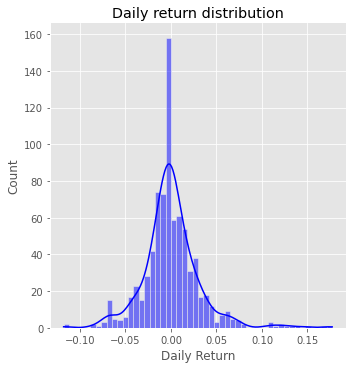

,Adj Close,Daily Return
Date,,
2021-01-02,2163.315674,0.000000
2021-01-03,2163.315674,0.000000
2021-01-04,2140.509521,-0.010542
2021-01-05,2179.605713,0.018265
2021-01-06,2169.831787,-0.004484
...,...,...
2023-03-08,1885.000000,-0.028351
2023-03-09,1875.000000,-0.005305
2023-03-10,1880.000000,0.002667


In [12]:
get_return(stock)

<AxesSubplot:xlabel='Date'>

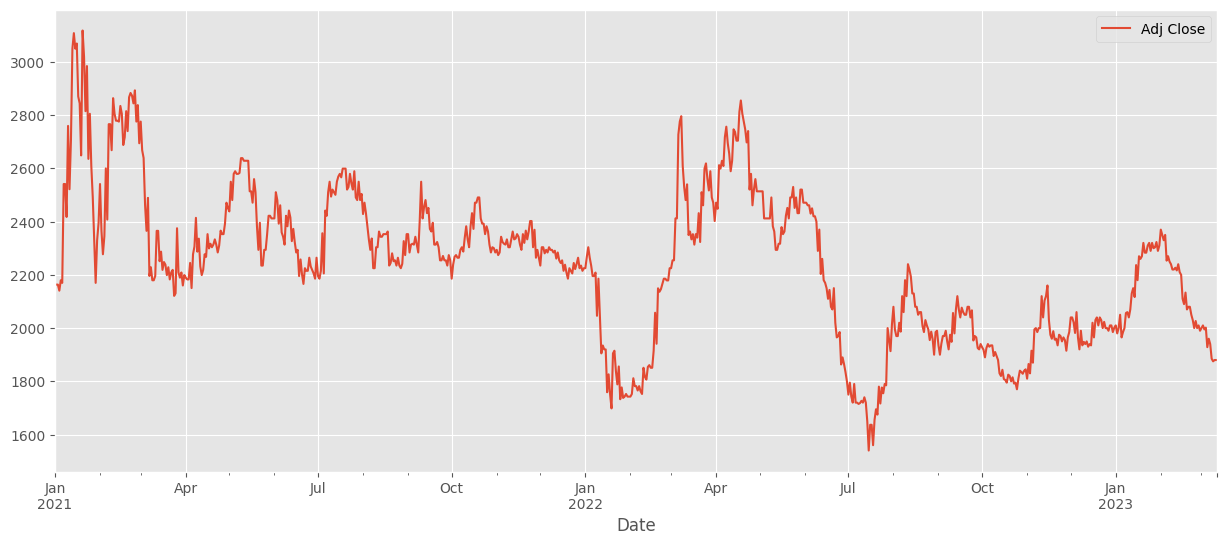

In [13]:
stock['Adj Close'].plot(legend = True, figsize = (15, 6))

In [14]:
n_sim = 1000
days = 60

In [15]:
def simulation(data, days, n_sim):   
    start_price = data.iloc[-1, 0]
    sim = np.zeros(n_sim)
    table = np.zeros((n_sim, days))

    delta = 1 / days
    mu = data['Daily Return'].mean()
    sigma = data['Daily Return'].std()
    def monte_carlo(start_price, days, mu = mu, sigma = sigma):
        price = np.zeros(days)
        price[0] = start_price
        
        shock = np.zeros(days)
        drift = np.zeros(days)
        
        for x in range(1, days):
            shock[x] = np.random.normal(loc = mu * delta, scale = sigma * np.sqrt(delta))
            drift[x] = mu * delta
            
            price[x] = price[x - 1] + (price[x - 1] * (drift[x] + shock[x]))
        
        return price

    plt.figure(figsize = (15, 8))
    for i in range(n_sim):
        result = monte_carlo(start_price, days)
        table[i] = result
        sim[i] = result[days - 1]
        plt.plot(result)
        
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title('Monte Carlo Analysis')

    return table

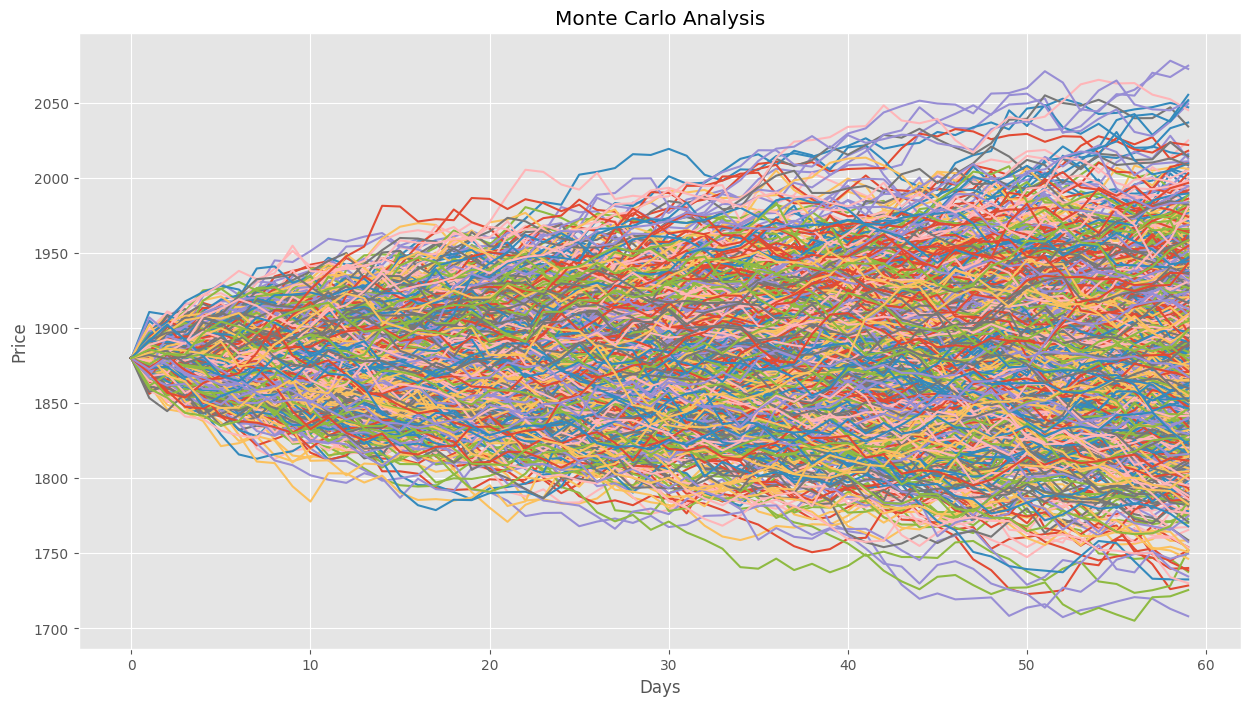

In [16]:
price = simulation(data = stock, days = days, n_sim = n_sim)

In [17]:
price

array([[1880.        , 1887.06723479, 1886.42019898, ..., 1896.21215918,
        1904.23919736, 1913.74358447],
       [1880.        , 1878.65609985, 1886.84352548, ..., 1980.67649486,
        1984.19321753, 1970.89327417],
       [1880.        , 1879.78547728, 1883.59590135, ..., 1993.73995655,
        2004.62769553, 2016.2533283 ],
       ...,
       [1880.        , 1882.13642769, 1879.63909622, ..., 1873.47276491,
        1862.03298832, 1851.29611346],
       [1880.        , 1883.7394962 , 1886.52985613, ..., 1897.60862955,
        1900.97922114, 1909.40146776],
       [1880.        , 1885.93609176, 1882.67910378, ..., 1941.14548045,
        1952.26235369, 1958.59200947]])

In [18]:
def trading_algo(mrx):
    '''
    0: Hold
    1: Sell
    2: Buy
    '''
    res = np.zeros((mrx.shape[0], mrx.shape[1]))
    n_sim = mrx.shape[0]

    for i in range(n_sim):
        j = 1
        while j != mrx.shape[1] - 1:
            start = j
            cond = True

            # Check increasing
            if mrx[i, j] > mrx[i, j - 1]:
                while cond:

                    # Still increasing and not at the end
                    if (mrx[i, j] > mrx[i, j - 1]) & (j != mrx.shape[1] - 1):
                        j = j + 1

                    # At the end or price dropped
                    else:
                        # Still increasing at the end, sell
                        if mrx[i, j] > mrx[i, j - 1]:
                            res[i, j] = 1
                            res[i, start: j] = 0
                            cond = False

                        # Price dropped, sell at prev price
                        else:
                            res[i, j - 1] = 1
                            res[i, start: j - 1] = 0
                            cond = False

            # Check decreasing
            else:
                while cond:
                    
                    # Still decreasing and not at the end
                    if (mrx[i, j] < mrx[i, j - 1]) & (j != mrx.shape[1] - 1):
                        j = j + 1

                    # At the end or price increased
                    else:
                        # Still decreasing at the end, buy
                        if mrx[i, j] < mrx[i, j - 1]:
                            res[i, j] = 2
                            res[i, start: j] = 0
                            cond = False

                        # Price increased, buy at prev price
                        else:
                            res[i, j - 1] = 2
                            res[i, start: j - 1] = 0
                            cond = False

    
    return res

In [19]:
decision = trading_algo(mrx = price)
decision

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 2., 0., ..., 2., 1., 0.],
       [0., 2., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 2., ..., 1., 0., 2.],
       [0., 0., 1., ..., 2., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [20]:
def trading_sim(price, decision, money):
    '''
    0: Hold
    1: Sell
    2: Buy
    '''
    res = np.zeros(price.shape[0])
    n_sim = price.shape[0]
    days = price.shape[1]

    for i in range(n_sim):
        # Initial stock at hand
        stock = money / price[i, 0]
        
        for j in range(days):
            # Hold
            if decision[i, j] == 0:
                pass

            # Sell
            elif decision[i, j] == 1:
                # Proportion of sell decision at given day
                arr = price[i, :]
                factor = (arr == 1).sum()

                curr_price = price[i, j]
                money = money + factor * stock * curr_price
                stock = (1 - factor) * stock

            # Buy
            else:
                # Proportion of buy decision at given day
                arr = price[i, :]
                factor = (arr == 2).sum()

                curr_price = price[i, j]
                money = (1 - factor) * money
                stock = stock + factor * money / curr_price

        # Final day result
        res[i] = money + stock * price[i, -1]

    pct_return = 100 * (res - money) / money
    
    return pct_return

In [21]:
money = 1e6
final_sim = trading_sim(price = price, decision = decision, money = money)
final_sim

array([101.79487151, 104.83474863, 107.24751746, 103.97494338,
        96.4235175 ,  95.34303624, 101.00517319,  95.36477958,
       103.78360898, 102.06498352,  97.3595678 , 101.32227142,
       104.79835412,  96.76556551,  99.30754281, 104.86131671,
       100.05266373,  99.14166296, 100.4457506 , 104.97755101,
       101.21774025, 100.90493949,  98.48553556,  95.81275718,
        97.3527417 ,  98.00953127, 104.53840084, 101.52263475,
        97.25057293, 100.97748288, 101.96324745, 100.76800265,
        98.04112238,  99.29029835,  98.4107492 , 101.10654583,
        96.4923882 , 102.57497669,  96.58781878,  99.66343684,
       102.35434735, 100.70216612,  99.58386132,  97.49090783,
       101.63917517,  98.39612089, 101.04684551, 101.41741817,
        99.5999094 ,  99.50764884,  95.42168365, 103.41015337,
       100.06651089,  97.80911641,  98.65724948, 103.13777984,
       101.81471245,  98.97189223,  98.80621342, 100.09181216,
       104.55748249,  98.74917238,  98.38309716,  94.42